In [1]:
import pandas 
import h5py
import os 
import pathlib
import natsort
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import pandas as pd 
import numpy as np
import numpy.ma as ma
import seaborn as sns
sns.set_theme(context = 'notebook', style = 'darkgrid', palette = 'colorblind')
import math
import collections
import warnings
import random
import uuid 
import datetime
from sklearn.preprocessing import StandardScaler
import sklearn.decomposition
import skimage
import skimage.measure
import skimage.segmentation
from skimage import morphology
import scipy
import napari
import tifffile
from scipy import stats
import pathlib 
from scipy.stats import norm
from matplotlib.patches import Circle, Ellipse
from sklearn.preprocessing import normalize
# import igor.packed

# import ipywidgets shtuff 
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

# Local imports 
import space 
import temporal
import plotting 
import utilities
import descriptives
import filehandling


# Notes to self 
- Last thing I did was create plotting.contouring and fix space.pixel_polarity by excluding frist and last frame 
- Now need to work out a way to accurately get STRF polarity (maybe it makes sense after extraction), and then correlate that with the ipl_depths
    - This can then become a method of Data_strf
    - Then work out a neat way to loop through files and grab this info from each file! 


# Loading data

## Load example array directly
First we load an example STRF to demo the existing functions (and to think of what needs to be done). In principle, the size and shape of the STRF data should not matter as long as it is a 3D numpy array. 

NOTE: The design principle behind STRF arrays is that the dimensions represent: array[time][y][x]

In [2]:
curr_cwd = os.getcwd()
example_RF = np.load(curr_cwd + "/demo_strf.npy")
print("Shape:", example_RF.shape, "Size:", example_RF.size)
anim, fig, ax, im = plotting.play_movie(example_RF, figaxim_return = True)
anim

Shape: (20, 60, 80) Size: 96000
Returning vars (animation, fig, ax)


## Post-processing
We keep post-processing to a minimum, but there are some steps that can be taken for convenience. 

The below example is computed for a white noise stimulus which is 60x80 (y,x) pixels, but a border of 8 pixels around the edges were ignored in the STRF calculation to speed up calculation. As a consequence, we are left with "grey" pixels. There are three ways to handle this, both with their own caveats: 1) Delete the border (but loosing original shape), 2) keep the border (but risk biasing subsequent calculations), or 3) mask the border (adding some complexity). Because shape may be important to retain, we choose option 3. 

In [3]:
border_mask = utilities.auto_border_mask(example_RF)
example_RF = np.ma.array(example_RF, mask = border_mask)# <--- this was stupid, just generate mask and MASK IT!! (preventing data loss etc)
print(f"Border mask is {utilities.check_border(border_mask[0])} wide")
anim,fig,ax,im = plotting.play_movie(example_RF, cmap = 'RdBu', figaxim_return = True)
fig.suptitle("Removed border")
anim

Border mask is 8 wide
Returning vars (animation, fig, ax)


The second pre-processing step is to normalize the semi-arbitrary values in the imported example_RF. This is not strictly neccisary, but by expresssing the values in z-scores it is more intuitive to interpret each data point and ensures that scales remain consistent between different RFs. It may also add a simple way to filter signal from noise when iterating through many RFs for automated analysis later on. The simplest and most efficent way to normalise arrays to z-score is probably using the Scipy package (scipy.stats.zscore) and computing the Z-scores for 'axis = None' which forces all values across the 3D array to be considered. 

In short, we Z-score normalise across all frames and all pixels, such that each pixel's value is the number of standard deviations from the entire spatiotemporal population's mean. Pixel-by-pixel, time point-by-point, the scale between values for a given RF remain identical. This is done automatically when using the filehandling.py module

In [17]:
example_rf_z = scipy.stats.zscore(example_RF, axis = None)
anim, fig, ax, im = plotting.play_movie(example_rf_z, cmap = 'RdBu', figaxim_return = True)
fig.suptitle("Z-scored")
ax.set_title("*Note colorbar")
anim

# f = r"c://Users/Simen/Desktop/animation_noborder_zscored.gif" 
# writergif = matplotlib.animation.PillowWriter(fps=10) 
# anim.save(f, writer=writergif)

Returning vars (animation, fig, ax)


# The 'filehandling' module
## Loading data from .h5 files 
In many cases, it is more convenient to automate data processing. As such, many files may need to be loaded at once. To facilitate this, the filehandling.py module contains several dataclasses. The first and by far most basic is the 'Data' dataclass. This class contains the following attributes:
- `fields`: The fields contained within the H5 file
- `metadata`: Metadata about the experiment 
- `images`: The imaging channel as extracted from Igor processing pipeline
- `rois`: A representaiton of the ROIs gathered from `images`

The 'Data_strf' class inherets these attributes and adds vast functinlaity, including the following:
- `strfs` : The pre-computed STAs for each ROI in `rois`
- `ipl_depths` : The pre-computed IPL depth for each ROI in `rois`

Moreover, 'Data_strf' objects have some neat methods, known as properties. These are implemented such that computation- and storage-heavy processes are optional. For example, if you wish to compute contours in the STRF, you can simply pass object.contours(), which will first check if a `self._contours` property exists. If not, it will compute it and set it as an object attribute. If it does exist, it will simply fetch that attribute.

This repository contains some demo data. This can be loaded via the following:

In [10]:
int(math.nan)

ValueError: cannot convert float NaN to integer

In [2]:
demo_file_path = pathlib.Path(os.getcwd()).joinpath("demo_data_strfs.h5")
vanilla_data = filehandling.load_data(demo_file_path)
strf_data = filehandling.load_strf_data(demo_file_path)

C:\Users\SimenLab\AppData\Local\Temp\ipykernel_20972\446208968.py:3: UserWarning: Old experiment detected, correcting for oversized STA
  strf_data = filehandling.load_strf_data(demo_file_path)
c:\Users\SimenLab\OneDrive\Universitet\PhD\GitHub repos\RF_analysis\filehandling.py:300: RuntimeWarning: invalid value encountered in cast
  boxes_tup = np.round(unit_conversion.calculate_boxes_on_screen(size), 0).astype('int') * hardcode_upscale


In [3]:
strf_data.metadata

{'filename': 'c:\\Users\\SimenLab\\OneDrive\\Universitet\\PhD\\GitHub repos\\RF_analysis\\demo_data_strfs.h5',
 'exp_date': datetime.date(2022, 10, 20),
 'exp_time': datetime.time(18, 6, 42),
 'objectiveXYZ': (-2170.2, 7218.4, -23804.0)}


The purpose is to use this file to read H5s nearly directly, but providing some quality of life improvements like transposing arrays, obtaining metadata easily, and providing functions to quickly and convenielty access these things.

On the surface, filehandling.py pretty much does what it says on the tin. It contains data classes for constructing objects which can store limited aspects of data and contain wrappers to the other modules associated with that type of data. For example, you can load up an .H5 containing various keys (these were written for internal use, so a system should be implemented to make data loading more flexible) such as 'STRF_n' (n is an int) which contain STRF arrays, or keys such as 'wDataCh0' which contains the imaging stack. This can be done simply by passing `data = filehandling.load_strf_data(path)`. In this case, we might want to do some operations on this data, such as collapse the 0th dimention (time) to get a 2D representation of the temporal events. This could be done for example in the following way:
```
collapsed_times = []
for i in data.strfs:
    collapsed_times.append(space.collapse_3d(data.strfs[i]))
```
However, this is verbose, annoying to repeat, and can even be considered a bit hacky. Instead, the classes in filehandling.py are written with convenience in mind. So, the above instead becomes:
```
example_data.collapse_time()
```
Which returns an array equivalent to the above collapsed_times list. The only thing to note is that the method 'collapse_time' does have some overhead, but every step is vectorised and in my testing computing the time-collapsed STRFs for 5 strfs in a file 100 times takes on average 0.8s. There is of course freedom to reconfigure the basis functions into your own functions rather than relying on the class methods. See example usage in plot below.

C:\Users\SimenLab\AppData\Local\Temp\ipykernel_9940\717213754.py:5: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


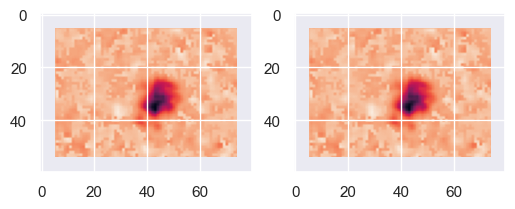

In [7]:
# These are equivalent
fig, ax = plt.subplots(1,2)
ax[0].imshow(space.collapse_3d(strf_data.strfs[14])) # Managable 
ax[1].imshow(strf_data.collapse_times()[14])          # Cleaner
fig.show()

The way `Data_strf.strf_masks()` is currently implemented makes it very powerful for vecotrised operations. The resulting array after running this contains the following axes: 0) STRF number, 1) Polarity (index 0 is -, 1 is +), 2) time, 3) y, 4) x. I.e., in a situation where a loaded Data_strf objecty contains 5 STRFs with 20 frames and spatial dimensions of (60,80), the resulting array will have shape (5, 2, 20, 60, 80). This is now leveraged in `Data_strf.timecourses()` which simply returns `np.average(self.strf_masks(), axis = (3,4))` for an array shape of (5, 2, 20) where index 0 is STRF, 1 is polarity, and 2 is time. 

## Space

Now we look at describing the spatial features. The function `space.collapse_3d()` is equivalent to:
```
# Get the polarity for each pixel in STRF
polarity_array = space.pixel_polarity(example_RF)
# Collapse space via temporal correlation 
corr_map = space.corr_spacetime(example_RF)
# Put polarity back into the correlation map
Spatial_RF = corr_map * polarity_array
```
In the next few cells you will see each one initialsied as arrays for illustrating this process. 

Next, we need to normalise the Spatial_RF so that RFs are more directly comparable. As is, the numbers are by default essentially arbitrary units (or rather, averaged and weighted values of the STA calculation). We will instead express these in Z-scores, essentially describing the number of standard deviations a given data point is away from the baseline standard deviation. 

As of now, the baseline standard deviation is defined from the first frame in the STRF, which is highly unlikely to contain meaningful signal.
This is equivalent to:
```
# First we get the mask for which the baseline should be calculated
pre_existing_border_width = utilities.check_border(Spatial_RF.mask)
border_width = 5
border_mask = utilities.manual_border_mask(Spatial_RF.shape, border_width + pre_existing_border_width)
edge_mask = np.ma.array(Spatial_RF, mask = border_mask)
edge_stdev = np.std(edge_mask)
Spatial_RF_stdev = (corr_map / edge_stdev) * polarity_array # Z-scored
```

Luckily, `space.collapse_3d()` does this for us as `zscore = True` by default

In [8]:
# Simple and silly benchmark 
for i in range(1000):
    space.collapse_3d(example_RF)

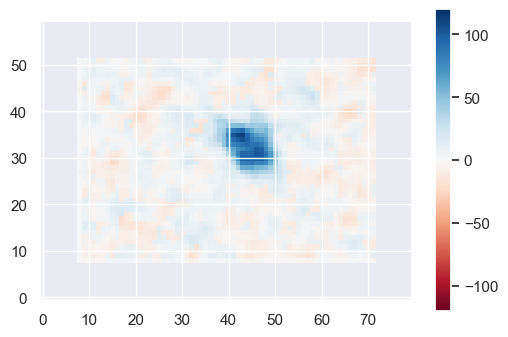

In [9]:
plt.imshow(space.collapse_3d(example_RF, zscore = True), origin = 'lower', cmap = 'RdBu')
plt.clim(-120, 120)
plt.colorbar()

The below cells simply illustrates the back-end of space.collapse_3d()

In [10]:
Spatial_RF = space.collapse_3d(example_rf_z)
# Get the polarity for each pixel in STRF
polarity_array = space.pixel_polarity(example_rf_z)
# Collapse space via temporal correlation 
corr_map = space.corr_spacetime(example_rf_z) #space.corr_spacetime(example_RF)
# Combined the two arrays 
corr_map_pol = polarity_array * corr_map

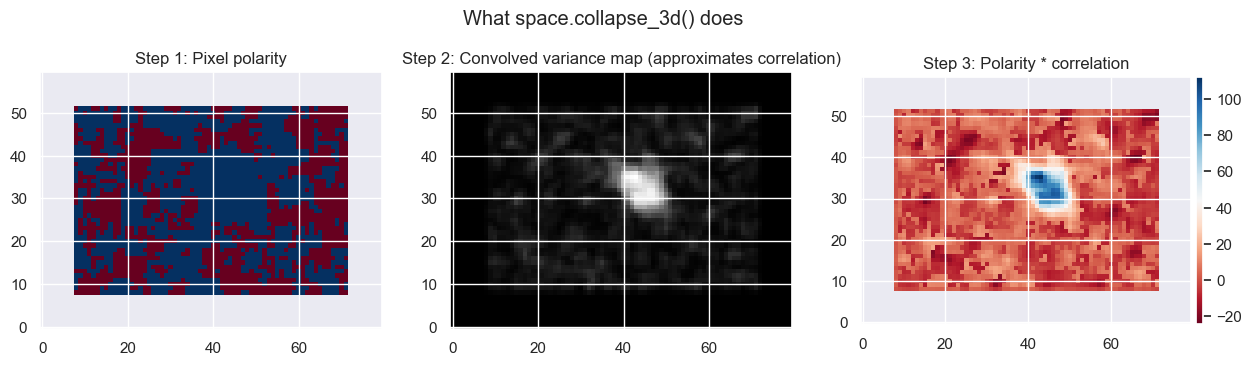

In [11]:
# Now we summarise what we have done as plots
fig, ax = plt.subplots(1, 3, figsize=(15, 4))
fig.suptitle("What space.collapse_3d() does")
divider1 = make_axes_locatable(ax[2])
cax1 = divider1.append_axes('right', size='2%', pad=0.05) #autoscaling "pretend" axis to append colorbar to

ax[0].set_title("Step 1: Pixel polarity")
ax[0].imshow(polarity_array, cmap = 'RdBu', origin = "lower")
ax[1].set_title("Step 2: Convolved variance map (approximates correlation)")
ax[1].imshow(corr_map, cmap = 'Greys_r', origin = "lower")
ax[2].set_title("Step 3: Polarity * correlation")
corrpol = ax[2].imshow(Spatial_RF, cmap = 'RdBu', origin = "lower")
fig.colorbar(corrpol, cax = cax1)

Below is a comparison between the computationally expensive way of determining the correlation between every pixel and its neighbour, and the relatively similar result of the very rapid calculation of convolving the STRF by a 3x3x1 kernel and then taking the variance in time of the resulting array. 

Text(0.5, 0.98, 'Comparison of correlation measures')

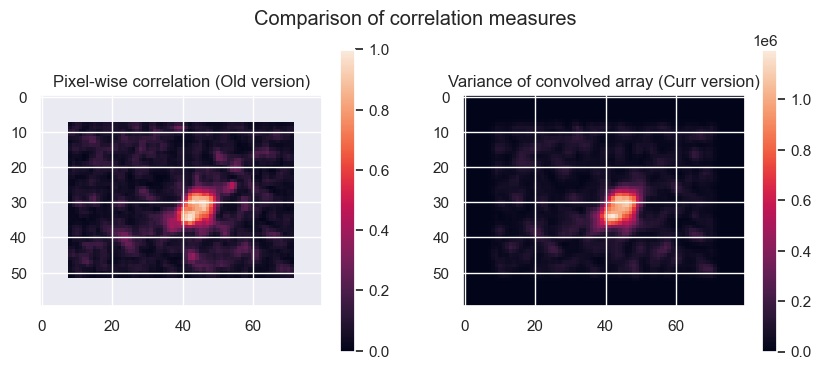

In [12]:
experimental = space.corr_spacetime(example_RF, mode = 'var', kernel_width=3)
np_equiv = np.var(example_RF, axis = 0)
fig, ax = plt.subplots(1, 2, figsize = (10, 4))

ex1 = ax[0].imshow(space._legacy_corr_spacetime(example_RF))
ax[0].set_title("Pixel-wise correlation (Old version)")
fig.colorbar(ex1, ax = ax[0])

ex2 = ax[1].imshow(experimental)
ax[1].set_title("Variance of convolved array (Curr version)")
fig.colorbar(ex2, ax = ax[1])
plt.suptitle("Comparison of correlation measures")

Clearly, we have some meaningful structure in our time-collapsed representation of receptive field-space. Now we need to extract the data from this region of space, so let's isolate the responding region. For this we will use `space.rf_mask3d`, which will first collapse time (as above), and then apply the derived 2D mask to every frame in the 3D array. 

There are a few crucial components to understanding `space.rf_mask3d`:
1. First, the mask comes from the `space.contour()` function, which is in-essence a semi-complicated wrapper for `skimage.measure.find_contours`, with an in-built mechanisms for threhsolding, the 'level' parameter in the scikit-image function, and handling cases where the user may onlt want to return a unipolar contour (as opposed to the default bipolar contours, resulting in a tuple (neg_contours, pos_contours)). If the input array passes the criteria set by the argument 'abs_criteria' in `space.contour()` (which is currently set to a default value of 45), 
`_contour_determine_level()` is called (default to 3 standard deviations of the input array). These two functions are helper functions and are not intended to be regularily used outside of `space.contour` (hence the '_' prefix). **Note:** `space.contour` has now been rewrtiten such that it will either return a single list or a tuple containing two lists depending on whether the argument 'expect_bipolar' is False or True respectively. If criteria is not met, an empty list is returned. Masking still occurs, but everything will be masked. This behaviour can be over-ridden by passing the keyword argument 'level'. If 'expect_bipolar' is False, please pass an int or a float. Otherwise, pass a tuple as such: (lower_level, upper_level). If for whatever reason you want to preserve skimage's default value, you an pass the string `"scikit-default"` to level. 
2. Then, the contours generated (which will be a list of numpy arrays) are passed to `space.contour_mask`. This function takes 'contour_list' and 'shape_tup' (tuple stating shape of desired output, within `space.rf_mask3d` this defaults to input-array's shape) as inputs. This generates a binary mask where the indeces to be kept are 0's and the masked indeces are 1. **Note**: This may not work as intended in cases where the RF is very very small. (e.g, sub-pixel)
3. Finally, `space.rf_mask3d` returns a tuple of two masked Numpy arrays with the above contours applied as masks. **NOTE:** For simplicity and consistency, `space.rf_mask3d` is written such taht 'expect_bipolar' is always true. The result is that if a negative mask (or vice versa) is not generated, it simply returns a tuple with an empty list for that index.

TL;DR: (Collapse time if needed), determine if SD is high enough, draw contours at 3 SDs of input array, make a mask for those contours, and apply. 

Et voi la, we have contoured and masked the STRF. This process is built-in and happens each time you call space.rf_mask3d(). So no need to do the above steps each time, they should just be applied accordingly: 
```
masked_strf = space.rf_mask3d(arr_3d)
```
or 
```
masked_strf = Data_strf_obj.strf_masks3d()
```

The plot below (just run the cell and it should appear) shows this process visually.

DescribeResult(nobs=4800, minmax=(-24.700158201173707, 112.45450096752502), mean=3.8167934422910132, variance=266.59081844317905, skewness=3.1607062872107883, kurtosis=13.834174110149668) std: 16.325908204119507


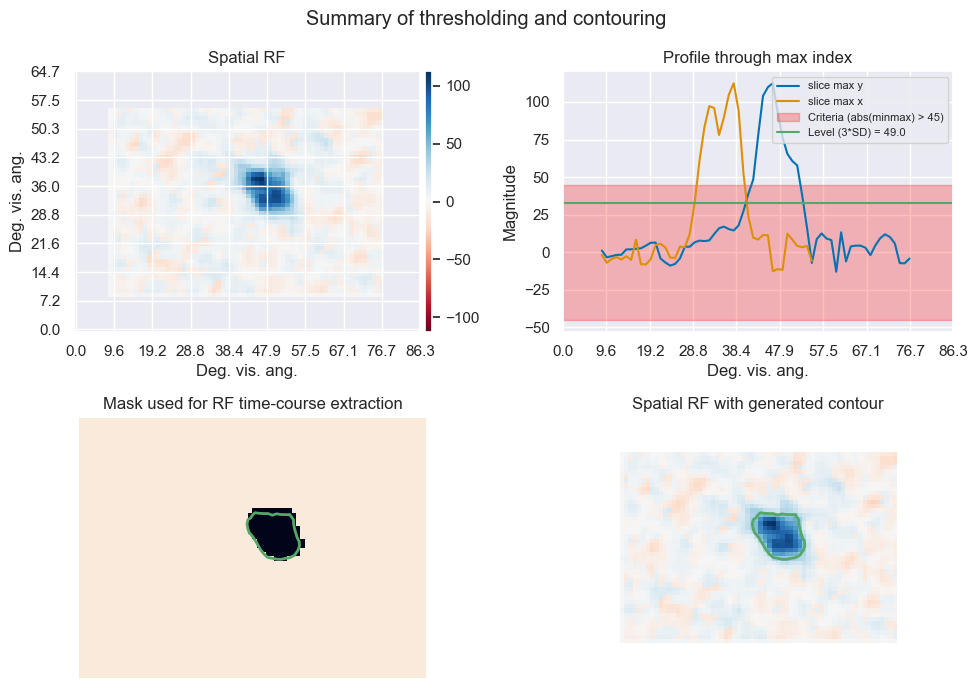

In [13]:
print(scipy.stats.describe(Spatial_RF, axis = None), "std:", np.std(Spatial_RF))
# Plotting
fig, ax = plt.subplots(2, 2, figsize = (10, 7))
# fig.tight_layout()
divider1 = make_axes_locatable(ax[0,0])
cax1 = divider1.append_axes('right', size='2%', pad=0.05) #autoscaling "pretend" axis to append colorbar to
# Original input RF
sp = ax[0,0].imshow(Spatial_RF, cmap = 'RdBu', origin = 'lower')
ax[0,0].set_title("Spatial RF")
ax[0, 0].set_xticks(np.linspace(0, Spatial_RF.shape[1], 10), np.round(np.linspace(0, Spatial_RF.shape[1], 10) * 4.315 / 4, 1))
ax[0, 0].set_yticks(np.linspace(0, Spatial_RF.shape[0], 10), np.round(np.linspace(0, Spatial_RF.shape[0], 10) * 4.315 / 4, 1))
ax[0, 0].set_ylabel("Deg. vis. ang.")
ax[0, 0].set_xlabel("Deg. vis. ang.")
fig.colorbar(sp, cax = cax1)
sp.set_clim(-np.max(Spatial_RF), np.max(Spatial_RF))
# 2D representation through max on Y and X axis
max_index = np.argwhere(np.abs(Spatial_RF) == np.max(np.abs(Spatial_RF)))[0]
ax[0, 1].plot(Spatial_RF[max_index[0], :], label = 'slice max y')
ax[0, 1].plot(Spatial_RF[:, max_index[1]], label = 'slice max x')
ax[0, 1].axhspan(-45, 45, alpha = 0.25, color = 'red', label = 'Criteria (abs(minmax) > 45)')
ax[0, 1].axhline(np.std(Spatial_RF) * 2, label = f'Level (3*SD) = {np.round(np.std(Spatial_RF * 3), 1)}', c = 'g')
ax[0, 1].legend(fontsize = 8)
ax[0, 1].set_title("Profile through max index")
ax[0, 1].set_xticks(np.linspace(0, Spatial_RF.shape[1], 10), np.round(np.linspace(0, Spatial_RF.shape[1], 10) * 4.315 / 4, 1))
ax[0, 1].set_ylabel("Magnitude")
ax[0, 1].set_xlabel("Deg. vis. ang.")
# Just the mask 
contour_ = space.contour_unipolar(Spatial_RF)
mask = ax[1, 0].imshow(space._contour_mask_unipolar(contour_, Spatial_RF.shape), origin = 'lower')
ax[1, 0].set_title("Mask used for RF time-course extraction")
ax[1, 0].axis("off")
# Spatial RF with contour
sp = ax[1, 1].imshow(Spatial_RF, cmap = 'RdBu', origin = 'lower')
ax[1, 1].set_title("Spatial RF with generated contour")
ax[1, 1].set_xticks(np.linspace(0, Spatial_RF.shape[1], 10), np.round(np.linspace(0, Spatial_RF.shape[1], 10) * 4.315 / 4, 1))
ax[1, 1].set_yticks(np.linspace(0, Spatial_RF.shape[0], 10), np.round(np.linspace(0, Spatial_RF.shape[0], 10) * 4.315 / 4, 1))
ax[1, 1].axis("off")
fig.colorbar(sp, cax = cax1)
sp.set_clim(-np.max(Spatial_RF), np.max(Spatial_RF))
for j in contour_ :
    ax[1, 1].plot(j[:, 1], j[:, 0], linewidth=2, ls = '-', c = 'g')# contour
    ax[1, 0].plot(j[:, 1], j[:, 0], linewidth=2, ls = '-', c = 'g')# contour

fig.suptitle("Summary of thresholding and contouring")
fig.tight_layout()

A simplified representaiton can be easily plotted in the following way:

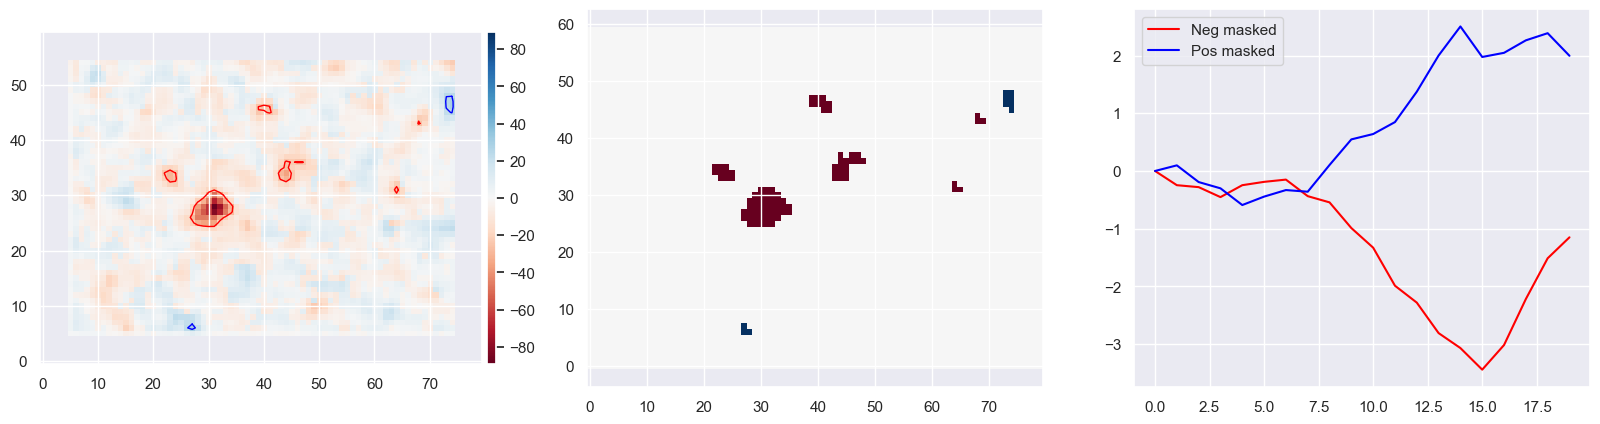

In [14]:
plotting.contouring(strf_data.strfs[1], display_time=True) # 12

# Time

### Extracting time course
Segueing into the time domain, we will apply the masked hotspot to every frame in time allowing more refined anaylsis of time-courses of the pixels with high degree of correlation. The obvious next step is to extract the time-course of the STRF. We can do this simply as follows:

In [4]:
time_course1, time_course2 = temporal.extract_timecourse(example_RF)
plt.plot(time_course1)
plt.plot(time_course2)

NameError: name 'example_RF' is not defined

This function is simple. It takes as an input a 3D STRF and creates a mask as described above using `space.rf_mask3d`, and then calculates the average pixel value in the remaining unmasked array along axes (1,2), i.e. space, using `np.average(ma_arr, axis = (1,2)`. Because this function relies on `space.rf_mask3d`, the 'level' parameter is exposed and can be set by passing a float or int. However, if level is None (as by default), the above algorithms will determine the level.

You may be wondering why `temporal.extract_timecourse` returns two arrays. This is simply because `space.rf_mask3d` gives two masked arrays. One representing negative components of the RF, and the other positive compponents. Having access to both allows more in-depth analysis. In the above plot, however, we only see one trace. That is because time_course1 is empty, as we can easily deduce by insepcting it. Therefore, in this case, we can be reasonibly certain that this RF does not have a significant negative component. 

Below is a comparison between extracting the time courses by this method vs. by averaging the entire array vs. extracting the values from the "brightest"/max-amplitude pixel. There is no correct method, but from my testing the masking and averaging method seems sensible. 

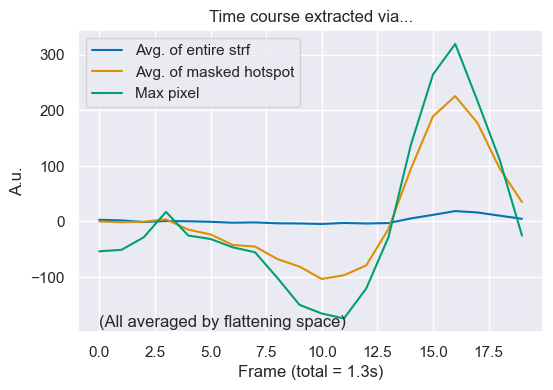

In [16]:
# Average across unmasked array (useless unless RF is sufficinetly large)
avg_strf_timecourse = np.average(example_RF, axis = (1, 2))
# Arguably less useless but uncertain how representative this is
max_loc = np.argwhere(example_RF == np.max(example_RF))[0]
max_pixl_timecourse = example_RF[:, max_loc[1], max_loc[2]]

fig, ax = plt.subplots()
ax.plot(avg_strf_timecourse, label = 'Avg. of entire strf')
ax.plot(time_course2, label = 'Avg. of masked hotspot')
ax.plot(max_pixl_timecourse, label = 'Max pixel')
ax.set_ylabel("A.u.")
ax.set_xlabel("Frame (total = 1.3s)")
ax.set_title("Time course extracted via...")
ax.text(0,-190,"(All averaged by flattening space)")
ax.legend()

Now that we have our time course, we should start quantifying some of the things we observe.

### Timing
Onset, time-to-min, time-to-max (could be index) and the difference between them 

Implement: 
- Timing: 
- Stimulus-polarity-index

### Amplitude
- Amplitude (think it through) 

### Stimulus-polarity index
The relative weighting of positive and negativce components. Think of it as area under the curve centred on 0 
- For this need to make sure all RFs start at 0 (should be straight forward, just subtract value of first index from everything)

AttributeError: module 'temporal' has no attribute 'polarity_index'

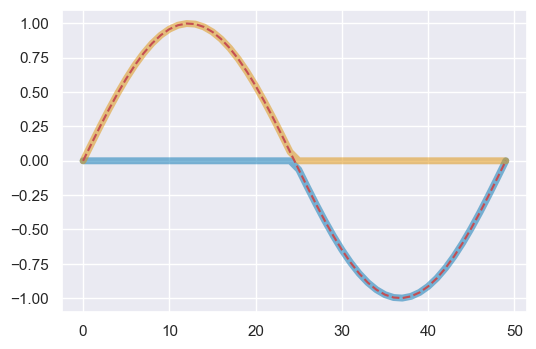

In [17]:
X = np.sin(np.linspace(0, np.pi*2))
X_lower = np.clip(X, np.min(X) - 1, 0)
X_upper = np.clip(X, 0, np.max(X) + 1)
plt.plot(X_lower.T, lw = 5, alpha = 0.5)
plt.plot(X_upper.T, lw = 5, alpha = 0.5)
plt.plot(X.T, ls = 'dashed', c = 'r')
val = temporal.polarity_index(X)
print("Index:", val)

Rho corrs:
tc, tc_y_offset:         1.0
tc, tc_x_offset:         0.30526315789473685
tc, tc_invert:           -1.0
tc, tc_invrert + noise:  -0.23308270676691725


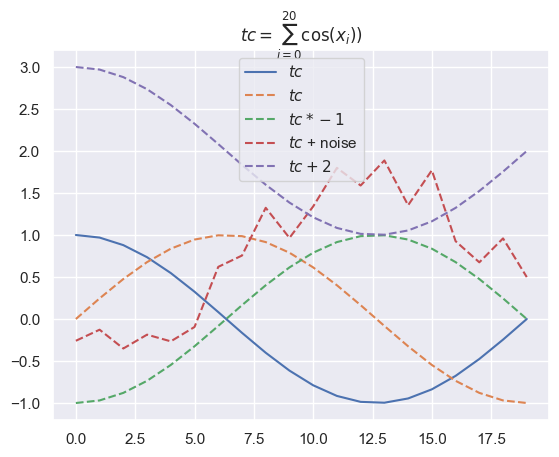

In [ ]:
## Spearmans Rho demo
# Maths
series = np.linspace(0, np.pi * 1.5, 20)
x = np.cos(series)
x_xoffset = np.sin(series)
x_yoffset = x + 2
x_inv = np.cos(series) * -1
x_inv_noise = x_inv + np.random.rand(20) 
# Plots
plt.plot(x, label = r'$tc$')
plt.plot(x_offset, label = r'$tc$', ls = '--')
plt.plot(x_inv, label = r'$tc * -1$', ls = '--')
plt.plot(x_inv_noise, label = r'$tc$ + noise', ls = '--')
plt.plot(x_yoffset, label =r'$tc + 2$', ls = '--')
plt.title("$  tc = \sum_{i=0}^{20} \cos(x_i))$")
plt.legend()
# Stats
print("Rho corrs:")
print("tc, tc_y_offset:        ", scipy.stats.spearmanr(x, x_yoffset)[0])
print("tc, tc_x_offset:        ", scipy.stats.spearmanr(x, x_xoffset)[0])
print("tc, tc_invert:          ", scipy.stats.spearmanr(x, x_inv)[0])
print("tc, tc_invrert + noise: ", scipy.stats.spearmanr(x_offset, x_inv_noise)[0])


### Spectral centroid
Another such paramter is to identify the frequency of the extracted time-course. *Spectral centroid* is convenient tool for this. It originates from digital signal processing and is typically used to characterise timbre of music and can be used to quantify how bright a given sound is percieved as being. Mathematically, it is the weighted mean of Fourier Transform of a time series, using the magnitudes of the FT as weights, which determines the spectrums centre of mass. In short time series this has the benefit of approximating the "most present" frequency. In our case, we can take this as a measure of the frequency of the extracted time series. 


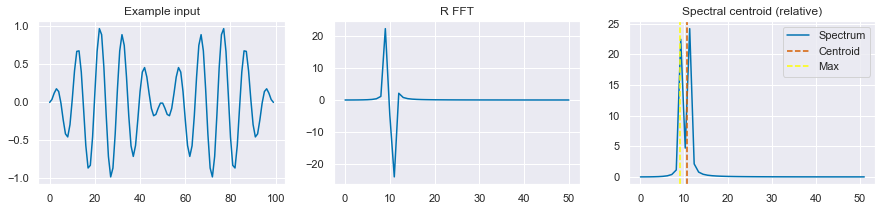

In [8]:
sinusoid = np.sin(np.linspace(0, 2*np.pi * 1 , 100)) * np.sin(np.linspace(0, 2*np.pi * 10, 100))
spectrum_dummydata, frequencies_dummydata, centroid_dummydata = temporal.spectral_centroid(sinusoid, sampling_rate=None)
fig, ax = plt.subplots(1, 3, figsize = (15, 3))
ax[0].plot(sinusoid)
ax[0].set_title("Example input")
ax[1].plot(np.fft.rfft(sinusoid))
ax[1].set_title("R FFT")
ax[2].plot(frequencies_dummydata, spectrum_dummydata, label = "Spectrum")
ax[2].axvline(centroid_dummydata, c= 'r', ls = '--', label = "Centroid")
ax[2].axvline(np.where(np.fft.rfft(sinusoid) == np.max(np.fft.rfft(sinusoid))), c= 'yellow', ls = '--', label = "Max")

# ax[2].set_xticks(np.linspace(0, 1, 11), np.linspace(0, 50, 11))
# ax[2].set_xticks(np.linspace(0, 1, 6), (np.linspace(0, len(sinusoid)/2, 6)))
ax[2].set_title("Spectral centroid (relative)")
ax[2].legend()

(array([9], dtype=int64),)

In [10]:
spectrum, freqs, centroid = temporal.spectral_centroid(time_course2, sampling_rate = 15.625)

NameError: name 'time_course2' is not defined

NameError: name 'time_course2' is not defined

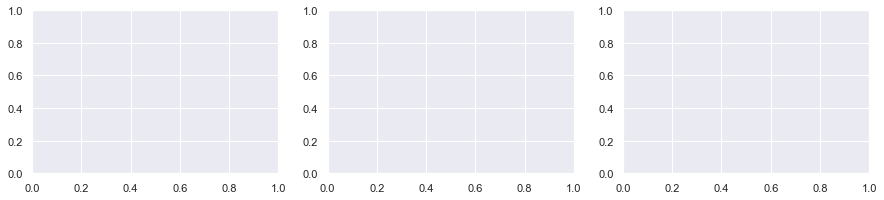

In [9]:
fig, ax = plt.subplots(1, 3, figsize = (15, 3))
ax[0].plot(time_course2)
ax[0].set_title("Example kernel")
ax[0].set_xlabel("Frames")
ax[1].plot(freqs, np.abs(np.fft.rfft(time_course2))) # shift for plotting purposes, not in real life>:s
ax[1].set_title("Example kernel's FFT")
ax[1].set_yscale("log")
# ax[1].set_xscale("log")
ax[1].set_xlabel("Freq.")
ax[2].plot(freqs, spectrum, label = 'Spectrum')
ax[2].axvline(x=centroid, c= 'r', ls = '--', label = "Centroid")
ax[2].set_title("Spectral centroid")
ax[2].set_xlabel("Freq.")
ax[2].set_yscale("log")
# ax[2].set_xscale("log")
ax[2].legend()

The most utility comes from the average of the masked hotspot, so for time-series analysis this is what we will stick to. 

# IPL position correlation 

One thing that would be natural to quantify is the polarity of the given STRF vs which layer of the IPL the cell it was computed from sat in. We already have access to `Data_strf.ipl_depth`, but polarity is a bit more tricky. The function `temporal.polarity` takes any time-course and determines whether the max or min index comes first, and assigns polarity as such. For example, if the max index comes before the min index, the timecourse has a negative polarity (and vice versa). This function takes an 'axis' argument, so it can theoretically be applied along any dimension. For a single time course it will return 0 or 1. For 2D array of timecourses it will return a 1D array of 0s and 1s. For a 3D array with specified axis it will return a 2D array of 0s and 1s. And so on. Therefore, since `Data_strf.timecourses()` is 3D (STRF, polarity [neg/pos], time), we will get a 2D array such as the following: 

```
>Data_strf.timecourses().shape
(21, 2, 20)

>Data_strf.timecourses()[0]
array([[ 0.93965859,  0.69327004,  0.6594869 ,  0.48655634,  0.69314744,
         0.7510549 ,  0.79002655,  0.50326582,  0.39538148, -0.04988966,
        -0.38970584, -1.04930203, -1.34221321, -1.87052616, -2.1298931 ,
        -2.50406558, -2.07723964, -1.28002415, -0.57360481, -0.21033899],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ]])
```

Now, this is useful, as we can account for STRFs which contain 2 opposing polarities. However, it makes data processing a bit of a pain to handle. One way to get around this is to assign values to a 1D array according to the polarities given by `Data_strf.timecourses()`. For example, we can assign [0, 0] if neither the positive or negative component has signal (e.g., no polarity), [-1, 0] if only the negative component has signal, [0, 1] for positive, and [-1, 1] for signal in both components. 

To plot this as a easily readable scatter plot, we would then need to collapse this again to be 1D rather than 2D. Note that in thios case, we assign the values as such:
- [ 0, 0]  : 0
- [-1, 0] : -1
- [ 0, 1]  : 1
- [-1, 1] : 2

We can do this as in the following cell:

In [ ]:
x = temporal.polarity(strf_data.timecourses(), exclude_FirstLast=(1, 1))
arr[np.where((x.data == (-0, 0)).all(axis=1))] = 0
arr[np.where((x.data == (-1, 0)).all(axis=1))] = -1
arr[np.where((x.data == (0, 1)).all(axis=1))] = 1
arr[np.where((x.data == (-1, 1)).all(axis=1))] = 2
arr

c:\Users\skrem\OneDrive\Universitet\PhD\GitHub repos\RF_analysis\space.py:409: UserWarning: Upper contour did not pass threshold criteria
  contour_lower, contour_upper = _draw_contour_bipolar(arr_2d, abs_criteria)
c:\Users\skrem\OneDrive\Universitet\PhD\GitHub repos\RF_analysis\space.py:409: UserWarning: Lower contour did not pass threshold criteria
  contour_lower, contour_upper = _draw_contour_bipolar(arr_2d, abs_criteria)


array([nan, -1., nan, nan, nan, nan,  1., nan,  1.,  1., nan, nan, -1.,
       nan, -1., -1., -1.,  2., -1., -1., nan])

However, this is annoying to repeat. Therefore, filehandling.py comes into play again. We can simply pass `Data_strf.polarities` and the above calculation will happen under-the-hood so that the user can focus on what is important. For example, see the below cell:

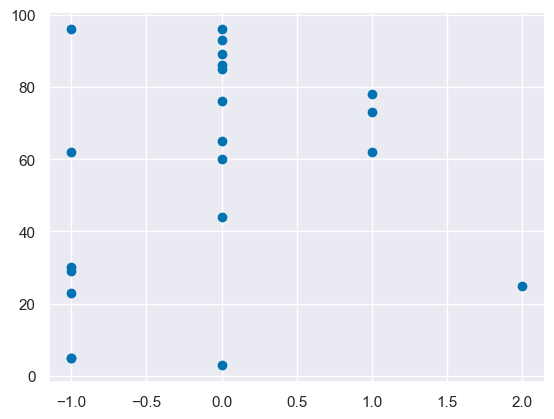

In [ ]:
plt.scatter(strf_data.polarities(),  strf_data.ipl_depths)
plt.show()

# Experimental section

In [ ]:
def rms(signal):
    return np.sqrt(1/len(signal) * np.square(signal))


rms = rms(avg_mask_timecourse)
plt.plot(rms)

NameError: name 'avg_mask_timecourse' is not defined

In [ ]:
def rms_env(signal, window = 1):
    x = np.empty(len(signal))
    
    np.sqrt(np.mean(signal**2))
    return x 

rms_env(avg_mask_timecourse)

array([ 63.28181311,  68.31276134,  60.71982766,  42.77640076,
       124.65686908, 163.83255076, 250.48934138, 265.84084434,
       368.98456673, 428.32716863, 527.77050523, 494.84587327,
       411.62028271, 113.60109708, 371.74228134, 800.45218603,
       959.22393074, 742.3315405 , 370.17629925,  97.9164991 ])

In [ ]:
def energy_envelope(signal):
    signal_rsm = np.sqrt(np.mean(signal**2))
    

def temporal_centroid():
    
    return 1, 1